In [21]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
import seaborn as sns
from ptflops import get_model_complexity_info
import math

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [22]:
# -------------------------
# BIT Architecture Implementation
# -------------------------

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch, dropout_rate=0.1, use_dropout=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        layers.extend([
            nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
        ])
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
        
        self.double_conv = nn.Sequential(*layers)

    def forward(self, x):
        return self.double_conv(x)

class CNNEncoder(nn.Module):
    """CNN backbone encoder for feature extraction"""
    def __init__(self, in_channels=3, features=[32, 64, 128, 256], dropout_rate=0.1):
        super().__init__()
        # No dropout in encoder layers
        self.enc1 = DoubleConv(in_channels, features[0], dropout_rate, use_dropout=False)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = DoubleConv(features[0], features[1], dropout_rate, use_dropout=False)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = DoubleConv(features[1], features[2], dropout_rate, use_dropout=False)
        self.pool3 = nn.MaxPool2d(2)
        self.enc4 = DoubleConv(features[2], features[3], dropout_rate, use_dropout=False)
        self.pool4 = nn.MaxPool2d(2)
        
        # Bottleneck with dropout
        self.bottleneck = DoubleConv(features[3], features[3] * 2, dropout_rate * 2, use_dropout=True)
        
    def forward(self, x):
        # Return all intermediate features for skip connections
        e1 = self.enc1(x)
        p1 = self.pool1(e1)
        
        e2 = self.enc2(p1)
        p2 = self.pool2(e2)
        
        e3 = self.enc3(p2)
        p3 = self.pool3(e3)
        
        e4 = self.enc4(p3)
        p4 = self.pool4(e4)
        
        # Bottleneck
        bottleneck = self.bottleneck(p4)
        
        return [e1, e2, e3, e4, bottleneck]

class PositionalEncoding(nn.Module):
    """Positional encoding for transformer"""
    def __init__(self, d_model, max_len=5000, dropout_rate=0.1):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    """Custom transformer encoder layer with regularization"""
    def __init__(self, d_model, nhead=8, dim_feedforward=512, dropout_rate=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout_rate, batch_first=True)
        
        # Feed forward network
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate),
            nn.Linear(dim_feedforward, d_model),
        )
        
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.dropout2 = nn.Dropout(dropout_rate)

    def forward(self, src):
        # Self-attention
        src2, _ = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        
        # Feed forward
        src2 = self.ffn(src)
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        
        return src

class FeatureFusion(nn.Module):
    """Feature fusion module for combining features from two branches"""
    def __init__(self, channels, dropout_rate=0.1, use_dropout=True):
        super().__init__()
        layers = [
            nn.Conv2d(channels * 2, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
        ]
        if use_dropout:
            layers.append(nn.Dropout2d(dropout_rate))
            
        self.fusion_conv = nn.Sequential(*layers)
        
    def forward(self, f1, f2):
        # Concatenate features from both branches
        fused = torch.cat([f1, f2], dim=1)
        return self.fusion_conv(fused)

class BIT(nn.Module):
    """BIT (Binary Image Transformer) for change detection with regularization"""
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128, 256], 
                 dropout_rate=0.2, nhead=8, num_transformer_layers=2):
        super().__init__()
        
        # CNN backbone encoder for both branches
        self.encoder = CNNEncoder(in_channels, features, dropout_rate)
        
        # Transformer parameters
        self.d_model = features[3] * 2  # 512 for bottleneck features
        self.patch_size = 16  # Size of patches for transformer
        
        # Feature fusion modules for each level (no dropout in encoder feature fusion)
        self.fusion1 = FeatureFusion(features[0], dropout_rate, use_dropout=False)
        self.fusion2 = FeatureFusion(features[1], dropout_rate, use_dropout=False)
        self.fusion3 = FeatureFusion(features[2], dropout_rate, use_dropout=False)
        self.fusion4 = FeatureFusion(features[3], dropout_rate=0.1, use_dropout=True)
        
        # Transformer components for bottleneck features
        self.pos_encoding = PositionalEncoding(self.d_model, dropout_rate=dropout_rate*2)
        self.transformer_layers = nn.ModuleList([
            TransformerEncoderLayer(self.d_model, nhead, dim_feedforward=self.d_model*2, 
                                  dropout_rate=dropout_rate*2)
            for _ in range(num_transformer_layers)
        ])
        
        # Projection layer for transformer output
        self.transformer_proj = nn.Sequential(
            nn.LayerNorm(self.d_model),
            nn.Dropout(dropout_rate*2),
            nn.Linear(self.d_model, self.d_model)
        )
        
        # Channel reduction layer for fused bottleneck features
        self.bottleneck_fusion = nn.Conv2d(self.d_model * 2, self.d_model, kernel_size=1, bias=False)
        
        # Decoder with dropout only in middle layers
        self.up4 = nn.ConvTranspose2d(features[3] * 2, features[3], kernel_size=2, stride=2)
        self.dec4 = DoubleConv(features[3] * 2, features[3], dropout_rate, use_dropout=True)
        
        self.up3 = nn.ConvTranspose2d(features[3], features[2], kernel_size=2, stride=2)
        self.dec3 = DoubleConv(features[2] * 2, features[2], dropout_rate, use_dropout=True)
        
        self.up2 = nn.ConvTranspose2d(features[2], features[1], kernel_size=2, stride=2)
        self.dec2 = DoubleConv(features[1] * 2, features[1], dropout_rate, use_dropout=True)
        
        self.up1 = nn.ConvTranspose2d(features[1], features[0], kernel_size=2, stride=2)
        self.dec1 = DoubleConv(features[0] * 2, features[0], dropout_rate, use_dropout=True)
        
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        
    def create_patches(self, x):
        """Convert feature maps to patches for transformer input"""
        B, C, H, W = x.shape
        # Flatten spatial dimensions
        patches = x.view(B, C, H * W).transpose(1, 2)  # [B, H*W, C]
        return patches
    
    def patches_to_feature_map(self, patches, H, W):
        """Convert patches back to feature maps"""
        B, N, C = patches.shape
        feature_map = patches.transpose(1, 2).view(B, C, H, W)  # [B, C, H, W]
        return feature_map
        
    def forward(self, x):
        # Split input into pre and post images
        pre_img = x[:, :3, :, :]   # First 3 channels
        post_img = x[:, 3:, :, :] # Last 3 channels
        
        # Extract features from both branches using shared encoder
        pre_features = self.encoder(pre_img)  # [e1, e2, e3, e4, bottleneck]
        post_features = self.encoder(post_img)
        
        # Fuse features at each level (except bottleneck)
        fused_e1 = self.fusion1(pre_features[0], post_features[0])
        fused_e2 = self.fusion2(pre_features[1], post_features[1])
        fused_e3 = self.fusion3(pre_features[2], post_features[2])
        fused_e4 = self.fusion4(pre_features[3], post_features[3])
        
        # Process bottleneck features with transformer
        pre_bottleneck = pre_features[4]  # [B, C, H, W]
        post_bottleneck = post_features[4]
        
        B, C, H, W = pre_bottleneck.shape
        
        # Create patches for transformer
        pre_patches = self.create_patches(pre_bottleneck)  # [B, H*W, C]
        post_patches = self.create_patches(post_bottleneck)
        
        # Concatenate pre and post patches for joint processing
        combined_patches = torch.cat([pre_patches, post_patches], dim=1)  # [B, 2*H*W, C]
        
        # Add positional encoding
        combined_patches = self.pos_encoding(combined_patches.transpose(0, 1)).transpose(0, 1)
        
        # Apply transformer layers
        transformer_out = combined_patches
        for layer in self.transformer_layers:
            transformer_out = layer(transformer_out)
        
        # Project transformer output
        transformer_out = self.transformer_proj(transformer_out)
        
        # Split back to pre and post features
        seq_len = H * W
        pre_transformed = transformer_out[:, :seq_len, :]  # [B, H*W, C]
        post_transformed = transformer_out[:, seq_len:, :]
        
        # Convert back to feature maps
        pre_transformed = self.patches_to_feature_map(pre_transformed, H, W)
        post_transformed = self.patches_to_feature_map(post_transformed, H, W)
        
        # Fuse transformed bottleneck features by concatenation then reduce channels
        fused_bottleneck = torch.cat([pre_transformed, post_transformed], dim=1)  # [B, 1024, H, W]
        
        # Reduce channels back to expected size for decoder using learnable projection
        fused_bottleneck = self.bottleneck_fusion(fused_bottleneck)  # [B, 512, H, W]
        
        # Decoder with skip connections using fused features
        d4 = self.up4(fused_bottleneck)
        d4 = torch.cat([d4, fused_e4], dim=1)
        d4 = self.dec4(d4)
        
        d3 = self.up3(d4)
        d3 = torch.cat([d3, fused_e3], dim=1)
        d3 = self.dec3(d3)
        
        d2 = self.up2(d3)
        d2 = torch.cat([d2, fused_e2], dim=1)
        d2 = self.dec2(d2)
        
        d1 = self.up1(d2)
        d1 = torch.cat([d1, fused_e1], dim=1)
        d1 = self.dec1(d1)
        
        # Output (return logits, not sigmoid)
        out = self.final_conv(d1)
        return out

In [23]:
# -------------------------
# Dataset Class for Earthquake Data
# -------------------------

class EarthquakeDataset(Dataset):
    """Custom dataset for earthquake damage assessment"""
    def __init__(self, root_dir, split='train', transform=None, img_size=(256, 256)):
        self.root_dir = root_dir
        self.split = split
        self.transform = transform
        self.img_size = img_size
        
        # Set paths based on split
        if split == 'train':
            self.pre_dir = os.path.join(root_dir, 'train', 'A_train_aug')
            self.post_dir = os.path.join(root_dir, 'train', 'B_train_aug')
            self.label_dir = os.path.join(root_dir, 'train', 'label_train_aug')
        elif split == 'val':
            self.pre_dir = os.path.join(root_dir, 'val', 'A_val')
            self.post_dir = os.path.join(root_dir, 'val', 'B_val')
            self.label_dir = os.path.join(root_dir, 'val', 'label_val')
        else:  # test
            self.pre_dir = os.path.join(root_dir, 'test', 'A_test')
            self.post_dir = os.path.join(root_dir, 'test', 'B_test')
            self.label_dir = os.path.join(root_dir, 'test', 'label_test')
        
        # Get list of image files
        self.image_files = sorted([f for f in os.listdir(self.pre_dir) if f.endswith('.png')])
    
    def __len__(self):
        return len(self.image_files)
    
    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        
        # Load images
        pre_img = Image.open(os.path.join(self.pre_dir, img_name)).convert('RGB')
        post_img = Image.open(os.path.join(self.post_dir, img_name)).convert('RGB')
        label = Image.open(os.path.join(self.label_dir, img_name)).convert('L')
        
        # Resize images
        pre_img = pre_img.resize(self.img_size)
        post_img = post_img.resize(self.img_size)
        label = label.resize(self.img_size)
        
        # Convert to tensors
        if self.transform:
            pre_img = self.transform(pre_img)
            post_img = self.transform(post_img)
        else:
            pre_img = transforms.ToTensor()(pre_img)
            post_img = transforms.ToTensor()(post_img)
        
        label = transforms.ToTensor()(label)
        
        # Ensure binary labels (0 or 1)
        label = (label > 0.5).float()
        
        # Concatenate pre and post images (6 channels total)
        combined_img = torch.cat([pre_img, post_img], dim=0)
        
        return combined_img, label

class EarlyStopping:
    """Early stopping to stop training when validation loss doesn't improve"""
    def __init__(self, patience=15, min_delta=1e-4, restore_best_weights=True):
        self.patience = patience
        self.min_delta = min_delta
        self.restore_best_weights = restore_best_weights
        self.best_loss = None
        self.counter = 0
        self.best_weights = None
        
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)
        elif self.best_loss - val_loss > self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.save_checkpoint(model)
        else:
            self.counter += 1
            
        if self.counter >= self.patience:
            if self.restore_best_weights:
                model.load_state_dict(self.best_weights)
            return True
        return False
    
    def save_checkpoint(self, model):
        """Saves model when validation loss decreases."""
        self.best_weights = model.state_dict().copy()

In [24]:
# -------------------------
# Loss Functions and Metrics
# -------------------------

def dice_coef(pred, target, smooth=1e-6):
    """Calculate dice coefficient"""
    pred = pred.contiguous()
    target = target.contiguous()
    intersection = (pred * target).sum(dim=(2,3))
    denom = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2. * intersection + smooth) / (denom + smooth)
    return dice.mean()

class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super().__init__()
        self.smooth = smooth

    def forward(self, pred, target):
        dice = dice_coef(pred, target, smooth=self.smooth)
        return 1.0 - dice

def combined_loss(logits, mask, bce_weight=0.6, dice_weight=0.4):
    """Combined BCE + Dice loss with balanced weights"""
    bce_loss = nn.BCEWithLogitsLoss()
    bce = bce_loss(logits, mask)
    probs = torch.sigmoid(logits)
    dice = DiceLoss()(probs, mask)
    return bce_weight * bce + dice_weight * dice

@torch.no_grad()
def compute_metrics_batch(logits, masks, thresh=0.5):
    """Compute metrics for a batch"""
    probs = torch.sigmoid(logits)
    preds = (probs >= thresh).float()
    preds_flat = preds.view(-1).cpu().numpy()
    masks_flat = masks.view(-1).cpu().numpy()
    
    # Handle edge case where all predictions or targets are same class
    unique_preds = np.unique(preds_flat)
    unique_masks = np.unique(masks_flat)
    
    if len(unique_preds) == 1 and len(unique_masks) == 1:
        if unique_preds[0] == unique_masks[0]:
            # Perfect prediction
            if unique_preds[0] == 1:
                tp, fp, fn, tn = len(preds_flat), 0, 0, 0
            else:
                tp, fp, fn, tn = 0, 0, 0, len(preds_flat)
        else:
            # Completely wrong prediction
            if unique_preds[0] == 1:
                tp, fp, fn, tn = 0, len(preds_flat), 0, 0
            else:
                tp, fp, fn, tn = 0, 0, len(preds_flat), 0
    else:
        cm = confusion_matrix(masks_flat, preds_flat, labels=[0,1])
        if cm.shape == (2, 2):
            tn, fp, fn, tp = cm.ravel()
        else:
            # Handle case where only one class present
            if cm.shape == (1, 1):
                if unique_masks[0] == 0:
                    tn, fp, fn, tp = cm[0,0], 0, 0, 0
                else:
                    tn, fp, fn, tp = 0, 0, 0, cm[0,0]
            else:
                tn, fp, fn, tp = 0, 0, 0, 0
    
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    return {"tn": int(tn), "fp": int(fp), "fn": int(fn), "tp": int(tp),
            "iou": float(iou), "dice": float(dice), "precision": float(precision),
            "recall": float(recall), "f1": float(f1), "acc": float(acc)}

In [25]:
# -------------------------
# Training and Validation Functions
# -------------------------

def train_one_epoch(model, loader, optimizer, scheduler=None):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Train batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        optimizer.zero_grad()
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        
        # Compute metrics for training accuracy
        metas = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += metas[k]
    
    if scheduler is not None:
        scheduler.step()
    
    # Calculate training accuracy
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    train_acc = (tp + tn) / (tp + tn + fp + fn + 1e-8)
    
    epoch_loss = running_loss / len(loader.dataset)
    return epoch_loss, train_acc

@torch.no_grad()
def validate(model, loader):
    """Validate model using the loader's existing batch size"""
    model.eval()
    running_loss = 0.0
    agg = {"tn":0,"fp":0,"fn":0,"tp":0}
    
    for imgs, masks in tqdm(loader, desc="Val batch"):
        imgs = imgs.to(device)
        masks = masks.to(device)
        logits = model(imgs)
        loss = combined_loss(logits, masks)
        running_loss += loss.item() * imgs.size(0)
        metas = compute_metrics_batch(logits, masks)
        for k in ["tn","fp","fn","tp"]:
            agg[k] += metas[k]
    
    tp, fp, fn, tn = agg["tp"], agg["fp"], agg["fn"], agg["tn"]
    eps = 1e-8
    iou = tp / (tp + fp + fn + eps)
    dice = (2 * tp) / (2 * tp + fp + fn + eps)
    precision = tp / (tp + fp + eps)
    recall = tp / (tp + fn + eps)
    f1 = 2 * precision * recall / (precision + recall + eps)
    acc = (tp + tn) / (tp + tn + fp + fn + eps)
    
    epoch_loss = running_loss / len(loader.dataset)
    metrics = {"loss": epoch_loss, "iou": iou, "dice": dice, "precision": precision,
               "recall": recall, "f1": f1, "acc": acc, 
               "confusion": np.array([[tn, fp], [fn, tp]])}
    return metrics

def train_model(model, train_loader, val_loader, num_epochs=50, learning_rate=1e-4, patience=15):
    """Training function with early stopping and regularization"""
    # More aggressive weight decay for regularization
    decay, no_decay = [], []
    for name, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if p.ndim == 1 or name.endswith(".bias"):
            no_decay.append(p)
        else:
            decay.append(p)

    optimizer = optim.AdamW(
        [
            {"params": decay, "weight_decay": 1e-3},  # Increased weight decay
            {"params": no_decay, "weight_decay": 0.0},
        ],
        lr=learning_rate,
    )
    
    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.7, patience=7, verbose=True, min_lr=1e-6
    )
    
    early_stopping = EarlyStopping(patience=patience, min_delta=1e-4)
    
    train_losses = []
    val_losses = []
    val_ious = []
    val_dices = []
    train_accs = []
    val_accs = []
    
    best_val_loss = float('inf')
    
    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase (batch_size=6)
        train_loss, train_acc = train_one_epoch(model, train_loader, optimizer)
        
        # Validation phase (batch_size=2)
        val_metrics = validate(model, val_loader)
        
        # Update scheduler
        scheduler.step(val_metrics['loss'])
        
        print(f"Train Loss: {train_loss:.6f} | Train Acc: {train_acc:.4f}")
        print(f"Val Loss: {val_metrics['loss']:.6f} | Val Acc: {val_metrics['acc']:.4f} | IoU: {val_metrics['iou']:.4f} | Dice: {val_metrics['dice']:.4f} | F1: {val_metrics['f1']:.4f}")
        print(f"Learning Rate: {optimizer.param_groups[0]['lr']:.2e}")
        
        # Store metrics
        train_losses.append(train_loss)
        val_losses.append(val_metrics['loss'])
        val_ious.append(val_metrics['iou'])
        val_dices.append(val_metrics['dice'])
        train_accs.append(train_acc)
        val_accs.append(val_metrics['acc'])
        
        # Save best model
        if val_metrics['loss'] < best_val_loss - 1e-4:
            best_val_loss = val_metrics['loss']
            torch.save(model.state_dict(), 'best_bit_earthquake.pth')
            print(f"Saved best model with validation loss: {best_val_loss:.6f}")
        
        # Check early stopping
        if early_stopping(val_metrics['loss'], model):
            print(f'Early stopping triggered after {epoch+1} epochs')
            break
    
    return train_losses, val_losses, val_ious, val_dices, train_accs, val_accs

In [26]:
# -------------------------
# Model Training Pipeline
# -------------------------

def main():
    # Hyperparameters - identical to Siamese U-Net
    BATCH_SIZE = 6  # Increased batch size for better gradients
    LEARNING_RATE = 2e-4  # Reduced learning rate
    NUM_EPOCHS = 200
    PATIENCE = 10  # Increased patience
    IMG_SIZE = (256, 256)
    
    # Simpler data transforms (no augmentation as requested)
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Dataset root directory
    root_dir = '/kaggle/input/finaldataset/earthquakeDataset'
    
    # Create datasets
    train_dataset = EarthquakeDataset(root_dir, split='train', transform=transform, img_size=IMG_SIZE)
    val_dataset = EarthquakeDataset(root_dir, split='val', transform=transform, img_size=IMG_SIZE)
    test_dataset = EarthquakeDataset(root_dir, split='test', transform=transform, img_size=IMG_SIZE)
    
    # Create data loaders - validation and test use batch_size=1 as requested
    train_loader = DataLoader(train_dataset, batch_size=6, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0, pin_memory=True)
    
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    
    # Initialize BIT model with same architecture and regularization as Siamese U-Net
    model = BIT(in_channels=3, out_channels=1, features=[32, 64, 128, 256], 
               dropout_rate=0.15, nhead=8, num_transformer_layers=2).to(device)
    
    # Count parameters
    total_params = sum(p.numel() for p in model.parameters())
    print(f"Total parameters: {total_params:,}")
    
    # Calculate GFLOPS
    try:
        # Use a sample input size of (6, 256, 256) for 6-channel input
        macs, params = get_model_complexity_info(model, (6, 256, 256), print_per_layer_stat=False, verbose=False)
        # Convert MACs to GFLOPS (1 GFLOP = 1e9 FLOPs, 1 MAC ≈ 2 FLOPs)
        gflops = float(macs.replace('GMac', '').replace('MMac', '').replace(' ', ''))
        if 'GMac' in macs:
            gflops = gflops * 2  # Convert GMac to GFLOPS
        elif 'MMac' in macs:
            gflops = gflops * 2 / 1000  # Convert MMac to GFLOPS
        print(f"Model GFLOPS: {gflops:.3f}")
    except Exception as e:
        print(f"Could not calculate GFLOPS: {e}")
        print("Make sure to install ptflops: pip install ptflops")
    
    # Train model
    print("Starting BIT training...")
    train_losses, val_losses, val_ious, val_dices, train_accs, val_accs = train_model(
        model, train_loader, val_loader, NUM_EPOCHS, LEARNING_RATE, PATIENCE
    )
    
    return model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader

# Run the training
model, train_losses, val_losses, val_ious, val_dices, train_accs, val_accs, test_loader = main()

Training samples: 2268
Validation samples: 189
Test samples: 189
Total parameters: 14,324,257
Model GFLOPS: 52.880
Starting BIT training...

Epoch 1/200


Val batch: 100%|██████████| 95/95 [00:08<00:00, 11.46it/s]


Train Loss: 0.578198 | Train Acc: 0.8554
Val Loss: 0.483397 | Val Acc: 0.8828 | IoU: 0.3587 | Dice: 0.5280 | F1: 0.5280
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.483397

Epoch 2/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.29it/s]


Train Loss: 0.452057 | Train Acc: 0.9004
Val Loss: 0.487125 | Val Acc: 0.8235 | IoU: 0.3188 | Dice: 0.4834 | F1: 0.4834
Learning Rate: 2.00e-04

Epoch 3/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.60it/s]


Train Loss: 0.401459 | Train Acc: 0.9115
Val Loss: 0.383746 | Val Acc: 0.9156 | IoU: 0.4088 | Dice: 0.5803 | F1: 0.5803
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.383746

Epoch 4/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.72it/s]


Train Loss: 0.372597 | Train Acc: 0.9182
Val Loss: 0.363396 | Val Acc: 0.9134 | IoU: 0.4478 | Dice: 0.6186 | F1: 0.6186
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.363396

Epoch 5/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.73it/s]


Train Loss: 0.349837 | Train Acc: 0.9237
Val Loss: 0.403135 | Val Acc: 0.8764 | IoU: 0.4090 | Dice: 0.5806 | F1: 0.5806
Learning Rate: 2.00e-04

Epoch 6/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.52it/s]


Train Loss: 0.331952 | Train Acc: 0.9284
Val Loss: 0.389367 | Val Acc: 0.8814 | IoU: 0.4093 | Dice: 0.5809 | F1: 0.5809
Learning Rate: 2.00e-04

Epoch 7/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.37it/s]


Train Loss: 0.317777 | Train Acc: 0.9309
Val Loss: 0.359458 | Val Acc: 0.9071 | IoU: 0.4441 | Dice: 0.6150 | F1: 0.6150
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.359458

Epoch 8/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.94it/s]


Train Loss: 0.299358 | Train Acc: 0.9364
Val Loss: 0.348511 | Val Acc: 0.9246 | IoU: 0.4638 | Dice: 0.6336 | F1: 0.6336
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.348511

Epoch 9/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.57it/s]


Train Loss: 0.287739 | Train Acc: 0.9398
Val Loss: 0.339780 | Val Acc: 0.9146 | IoU: 0.4795 | Dice: 0.6482 | F1: 0.6482
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.339780

Epoch 10/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.46it/s]


Train Loss: 0.275078 | Train Acc: 0.9428
Val Loss: 0.334679 | Val Acc: 0.9199 | IoU: 0.4990 | Dice: 0.6657 | F1: 0.6657
Learning Rate: 2.00e-04
Saved best model with validation loss: 0.334679

Epoch 11/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.01it/s]


Train Loss: 0.258680 | Train Acc: 0.9466
Val Loss: 0.348689 | Val Acc: 0.9265 | IoU: 0.4721 | Dice: 0.6414 | F1: 0.6414
Learning Rate: 2.00e-04

Epoch 12/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.20it/s]


Train Loss: 0.245680 | Train Acc: 0.9505
Val Loss: 0.369087 | Val Acc: 0.9075 | IoU: 0.4594 | Dice: 0.6296 | F1: 0.6296
Learning Rate: 2.00e-04

Epoch 13/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.24it/s]


Train Loss: 0.229180 | Train Acc: 0.9542
Val Loss: 0.357567 | Val Acc: 0.9144 | IoU: 0.4770 | Dice: 0.6459 | F1: 0.6459
Learning Rate: 2.00e-04

Epoch 14/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.56it/s]


Train Loss: 0.218575 | Train Acc: 0.9567
Val Loss: 0.372772 | Val Acc: 0.9216 | IoU: 0.4697 | Dice: 0.6392 | F1: 0.6392
Learning Rate: 2.00e-04

Epoch 15/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.49it/s]


Train Loss: 0.210637 | Train Acc: 0.9584
Val Loss: 0.368102 | Val Acc: 0.9148 | IoU: 0.4691 | Dice: 0.6386 | F1: 0.6386
Learning Rate: 2.00e-04

Epoch 16/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 15.92it/s]


Train Loss: 0.198146 | Train Acc: 0.9609
Val Loss: 0.384276 | Val Acc: 0.9123 | IoU: 0.4563 | Dice: 0.6266 | F1: 0.6266
Learning Rate: 2.00e-04

Epoch 17/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.59it/s]


Train Loss: 0.186597 | Train Acc: 0.9641
Val Loss: 0.366478 | Val Acc: 0.9193 | IoU: 0.4868 | Dice: 0.6548 | F1: 0.6548
Learning Rate: 2.00e-04

Epoch 18/200


Val batch: 100%|██████████| 95/95 [00:06<00:00, 15.68it/s]


Train Loss: 0.178459 | Train Acc: 0.9659
Val Loss: 0.385721 | Val Acc: 0.9234 | IoU: 0.4558 | Dice: 0.6261 | F1: 0.6261
Learning Rate: 1.40e-04

Epoch 19/200


Val batch: 100%|██████████| 95/95 [00:06<00:00, 15.52it/s]


Train Loss: 0.155318 | Train Acc: 0.9706
Val Loss: 0.375455 | Val Acc: 0.9263 | IoU: 0.4934 | Dice: 0.6608 | F1: 0.6608
Learning Rate: 1.40e-04

Epoch 20/200


Val batch: 100%|██████████| 95/95 [00:05<00:00, 16.25it/s]

Train Loss: 0.145707 | Train Acc: 0.9725
Val Loss: 0.384176 | Val Acc: 0.9167 | IoU: 0.4813 | Dice: 0.6499 | F1: 0.6499
Learning Rate: 1.40e-04
Early stopping triggered after 20 epochs


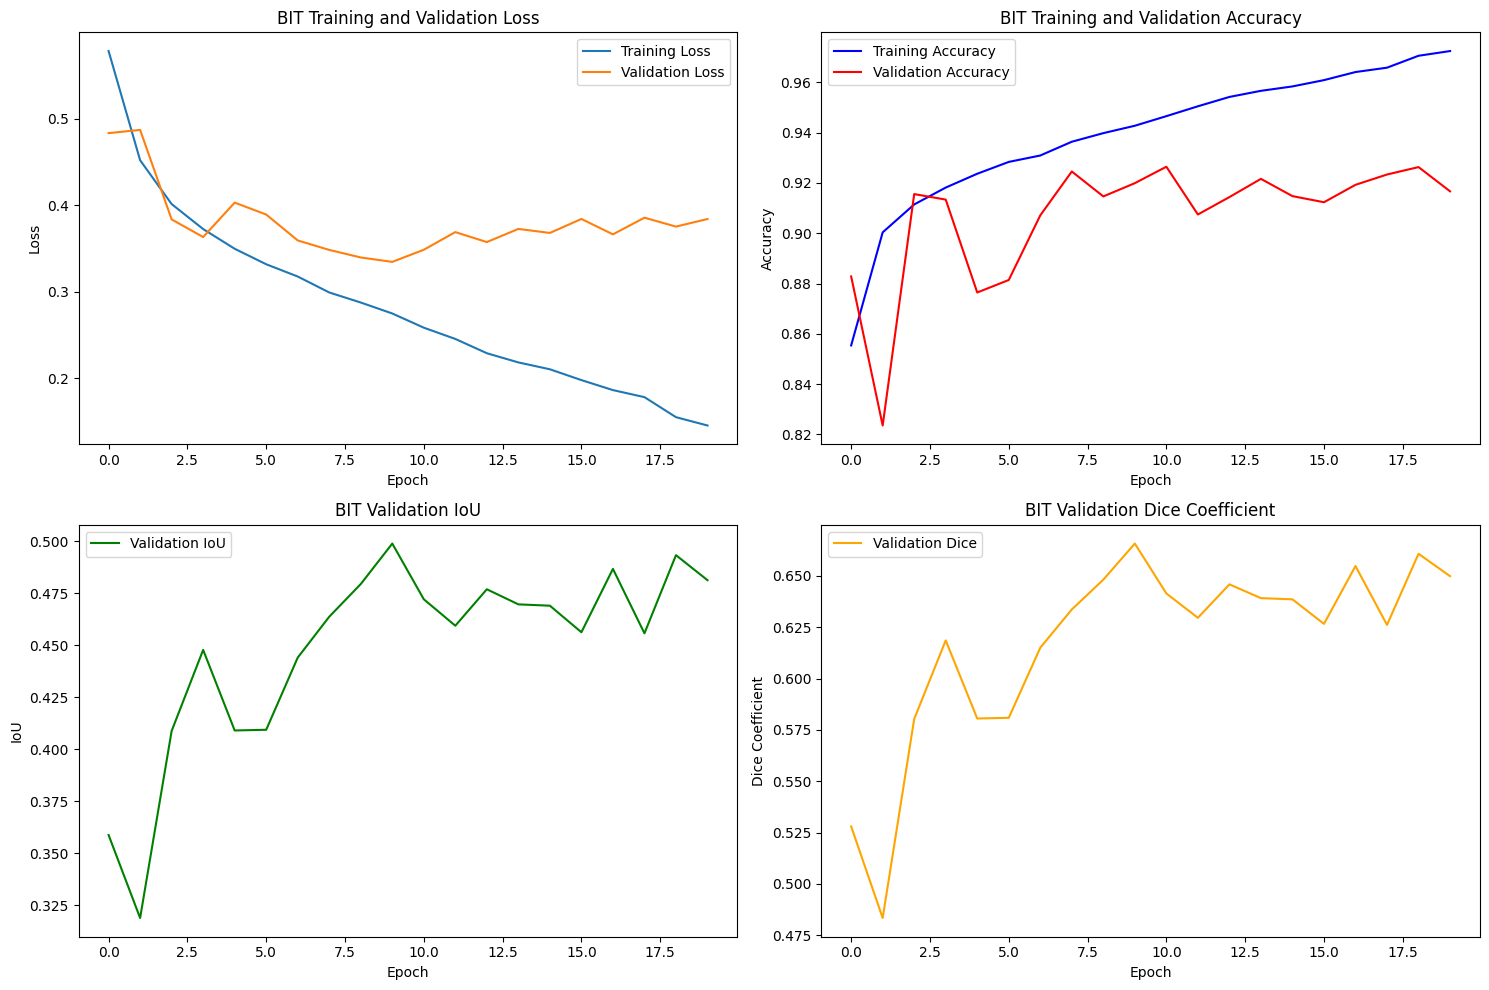

In [27]:
# -------------------------
# Results Visualization
# -------------------------

# Plot training curves
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# Loss curves
ax1.plot(train_losses, label='Training Loss')
ax1.plot(val_losses, label='Validation Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.set_title('BIT Training and Validation Loss')

# Accuracy curves
ax2.plot(train_accs, label='Training Accuracy', color='blue')
ax2.plot(val_accs, label='Validation Accuracy', color='red')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.set_title('BIT Training and Validation Accuracy')

# IoU curve
ax3.plot(val_ious, label='Validation IoU', color='green')
ax3.set_xlabel('Epoch')
ax3.set_ylabel('IoU')
ax3.legend()
ax3.set_title('BIT Validation IoU')

# Dice curve
ax4.plot(val_dices, label='Validation Dice', color='orange')
ax4.set_xlabel('Epoch')
ax4.set_ylabel('Dice Coefficient')
ax4.legend()
ax4.set_title('BIT Validation Dice Coefficient')

plt.tight_layout()
plt.savefig('bit_training_curves.png', dpi=300, bbox_inches='tight')
plt.show()

In [28]:
# -------------------------
# Test Evaluation
# -------------------------

# Load best model for testing
print("Loading best BIT model for test evaluation...")
model.load_state_dict(torch.load('best_bit_earthquake.pth', map_location=device))
model.to(device)

# Evaluate on test set (batch_size=1)
print("\nEvaluating BIT on test set...")
test_metrics = validate(model, test_loader)

# Print test metrics
print("\n" + "="*50)
print("BIT (BINARY IMAGE TRANSFORMER) TEST EVALUATION METRICS")
print("="*50)
print(f"Test set processed with batch_size=1")
print(f"Loss:            {test_metrics['loss']:.6f}")
print(f"IoU:             {test_metrics['iou']:.4f}")
print(f"Dice Coefficient: {test_metrics['dice']:.4f}")
print(f"Accuracy:        {test_metrics['acc']:.4f}")
print(f"Precision:       {test_metrics['precision']:.4f}")
print(f"Recall:          {test_metrics['recall']:.4f}")
print(f"F1-Score:        {test_metrics['f1']:.4f}")
print("Confusion matrix (pixel-level):")
print(test_metrics["confusion"])
print("="*50)

print("BIT training and evaluation completed!")

Loading best BIT model for test evaluation...

Evaluating BIT on test set...


Val batch: 100%|██████████| 189/189 [00:09<00:00, 20.23it/s]


BIT (BINARY IMAGE TRANSFORMER) TEST EVALUATION METRICS
Test set processed with batch_size=1
Loss:            0.332709
IoU:             0.4941
Dice Coefficient: 0.6614
Accuracy:        0.9257
Precision:       0.6396
Recall:          0.6847
F1-Score:        0.6614
Confusion matrix (pixel-level):
[[10566451   506714]
 [  414002   899137]]
BIT training and evaluation completed!
